In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
titanic_data =  pd.read_csv('data/train.csv')

In [3]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

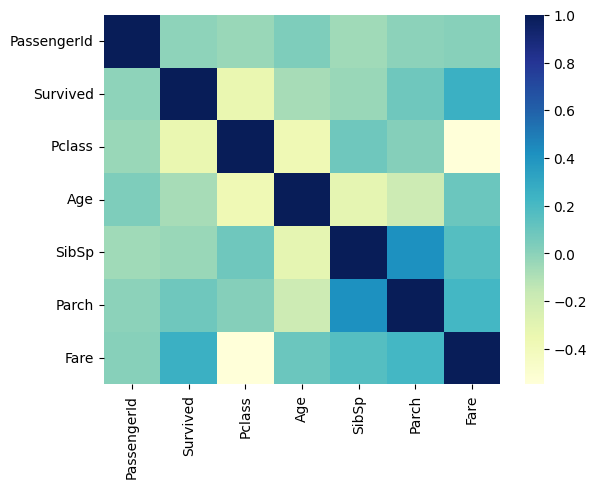

In [5]:
sns.heatmap(data = titanic_data.corr(numeric_only=True) , cmap='YlGnBu')

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits= 1 , test_size= 0.2)
for train_indices , test_indices in split.split(titanic_data , titanic_data[['Survived' , 'Pclass' , 'Sex']]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

In [7]:
strat_test_set.shape , strat_train_set.shape

((179, 12), (712, 12))

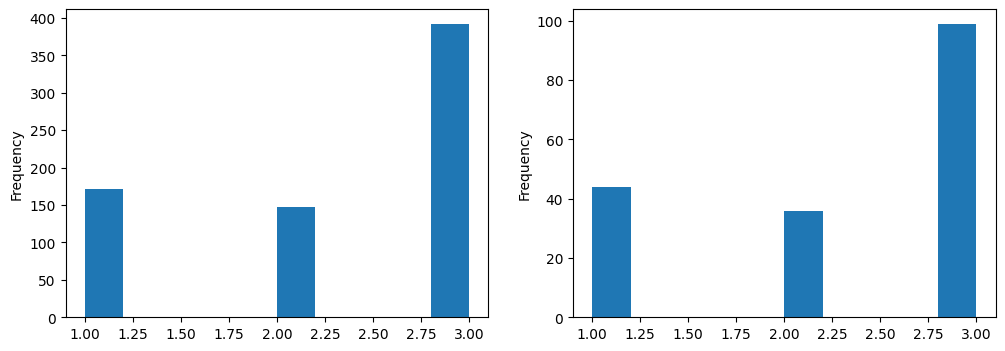

In [8]:
## check the distribution of Pclass and Survived
plt.figure(figsize=(12,4))
plt.subplot(121)
strat_train_set['Pclass'].plot.hist()

plt.subplot(122)
strat_test_set['Pclass'].plot.hist()

plt.show()



In [9]:
from sklearn.base import BaseEstimator , TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator , TransformerMixin):

    def fit(self , X , y=None):
        return self
    
    def transform(self , X):
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [10]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator , TransformerMixin):

    def fit(self , X , y = None):
        return self
    
    def transform(self , X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()

        column_names = ['C' , 'S' , 'Q' , 'N']
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        column_names = X['Sex'].unique()
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        return X

In [11]:
class FeatureDropper(BaseEstimator , TransformerMixin):

    def fit(self , X , y=None):
        return self
    
    def transform(self , X):
        return X.drop(['Embarked' , 'Name' , 'Ticket' , 'Cabin' , 'Sex' , 'N'] , axis = 1 , errors = 'ignore')

In [12]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('ageImputer' , AgeImputer()),
    ('featureEncoder' , FeatureEncoder()),
    ('featureDropper' , FeatureDropper())
])

In [13]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [14]:
strat_train_set.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,male,female
26,27,0,3,29.831603,0,0,7.2250,1.0,0.0,0.0,0.0,1.0
266,267,0,3,16.000000,4,1,39.6875,0.0,0.0,1.0,0.0,1.0
188,189,0,3,40.000000,1,1,15.5000,0.0,1.0,0.0,0.0,1.0
781,782,1,1,17.000000,1,0,57.0000,0.0,0.0,1.0,1.0,0.0
424,425,0,3,18.000000,1,1,20.2125,0.0,0.0,1.0,0.0,1.0


In [15]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [16]:
strat_test_set.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,female,male
612,613,1,3,29.155929,1,0,15.5000,0.0,1.0,0.0,1.0,0.0
381,382,1,3,1.000000,0,2,15.7417,1.0,0.0,0.0,1.0,0.0
558,559,1,1,39.000000,1,1,79.6500,0.0,0.0,1.0,1.0,0.0
711,712,0,1,29.155929,0,0,26.5500,0.0,0.0,1.0,0.0,1.0
397,398,0,2,46.000000,0,0,26.0000,0.0,0.0,1.0,0.0,1.0


In [17]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop('Survived' , axis = 1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [18]:
X_data

array([[-1.59758269,  0.82789342,  0.        , ..., -1.61119819,
        -0.73561236,  0.73561236],
       [-0.67104546,  0.82789342, -1.06075835, ...,  0.62065611,
        -0.73561236,  0.73561236],
       [-0.97217006,  0.82789342,  0.77982375, ..., -1.61119819,
        -0.73561236,  0.73561236],
       ...,
       [-1.25013123,  0.82789342,  3.11889683, ..., -1.61119819,
        -0.73561236,  0.73561236],
       [ 0.91178898,  0.82789342, -0.40888553, ...,  0.62065611,
        -0.73561236,  0.73561236],
       [ 1.5526439 , -1.56828591,  0.01291454, ..., -1.61119819,
         1.35941164, -1.35941164]], shape=(712, 11))

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()
param_grid = [
    {'n_estimators' : [10,100,200,500] , 'max_depth' : [None , 5, 10] , 'min_samples_split' : [2,3,4]}
]

grid_search = GridSearchCV(clf , param_grid , cv = 3 , scoring='accuracy' , return_train_score=True)
grid_search.fit(X_data ,y_data)

,estimator,RandomForestClassifier()
,param_grid,"[{'max_depth': [None, 5, ...], 'min_samples_split': [2, 3, ...], 'n_estimators': [10, 100, ...]}]"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,100


In [20]:
final_clf = grid_search.best_estimator_

In [21]:
final_clf

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,3
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
strat_test_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,female,male
612,613,1,3,29.155929,1,0,15.5000,0.0,1.0,0.0,1.0,0.0
381,382,1,3,1.000000,0,2,15.7417,1.0,0.0,0.0,1.0,0.0
558,559,1,1,39.000000,1,1,79.6500,0.0,0.0,1.0,1.0,0.0
711,712,0,1,29.155929,0,0,26.5500,0.0,0.0,1.0,0.0,1.0
397,398,0,2,46.000000,0,0,26.0000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
775,776,0,3,18.000000,0,0,7.7500,0.0,0.0,1.0,0.0,1.0
291,292,1,1,19.000000,1,0,91.0792,1.0,0.0,0.0,1.0,0.0
531,532,0,3,29.155929,0,0,7.2292,1.0,0.0,0.0,0.0,1.0
760,761,0,3,29.155929,0,0,14.5000,0.0,0.0,1.0,0.0,1.0


In [23]:
X_test = strat_test_set.drop(['Survived'] , axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()


In [24]:
final_clf.score(X_data_test , y_data_test)

0.7988826815642458

In [25]:
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [26]:
final_data = pipeline.fit_transform(titanic_data)

In [27]:
final_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,male,female
0,1,0,3,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.0,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [28]:
X_final = final_data.drop('Survived',  axis = 1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()
param_grid = [
    {'n_estimators' : [10,100,200,500] , 'max_depth' : [None , 5, 10] , 'min_samples_split' : [2,3,4]}
]

grid_search = GridSearchCV(clf , param_grid , cv = 3 , scoring='accuracy' , return_train_score=True)
grid_search.fit(X_data_final ,y_data_final)

,estimator,RandomForestClassifier()
,param_grid,"[{'max_depth': [None, 5, ...], 'min_samples_split': [2, 3, ...], 'n_estimators': [10, 100, ...]}]"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,100


In [30]:
titanic_test_data = pd.read_csv('data/test.csv')

In [31]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [32]:
final_test_data.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,S,Q,male,female
0,892,3,34.5,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.0,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.0,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.0,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.0,1,1,12.2875,0.0,0.0,1.0,1.0,0.0


In [33]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   male         418 non-null    float64
 10  female       418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.1 KB


In [34]:
X_final_test = final_test_data.ffill()

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)


In [36]:
predictions = grid_search.predict(X_data_final_test)

In [37]:
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [38]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv('data/predictions.csv' , index = False)

In [39]:
df = pd.read_csv('data/predictions.csv')

In [40]:
df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
